# Overview of Image-Based Two-Phase Flow Simulations - Part 2: Imbibition

PoreSpy includes several functions for simulation the displacement of one phase by another.  These include `drainage`, `imbibition`, and `invasion`.  The objectives of this tutorial are:

- Give an overview of the various ways to use the `porespy.simulations.imbibition` algorithm
- Demonstrate how the definition of inlets and outlets affects the result
- Expand on the concept of displacement maps introduced in Part 1 to focus on imbibition
- Explain the conventions used for dealing with trapped and residual phase in displacement maps
- Plot capillary pressure curves using the results of an imbibition simulation

## Setup

As usual, we start by importing the necessary packages, and creating a test image which will be used throughout.  The test image is 2D for visualization purposes, but everything discussed here applies to 3D as well.

In [1]:
import matplotlib.pyplot as plt
import numpy as np

import porespy as ps

ps.visualization.set_mpl_style()

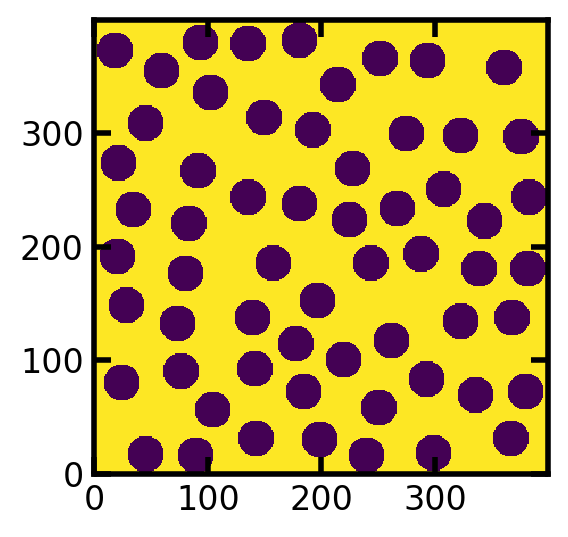

In [2]:
im = ~ps.generators.random_spheres([400, 400], r=15, clearance=10, seed=22)
fig, ax = plt.subplots(figsize=[3, 3])
ax.imshow(im);


## Pressure-Based Imbibition



### Define Inlets, Capillary Transform, and Run A Simulation


In [3]:
inlets = ps.generators.faces(im.shape, inlet=0)
pc = ps.filters.capillary_transform(
    im=im,
    sigma=0.01,
    theta=180,
    voxel_size=1e-4,
)
imb1 = ps.simulations.imbibition(
    im=im,
    pc=pc,
    inlets=inlets,
)

### Inspect Displacement Maps

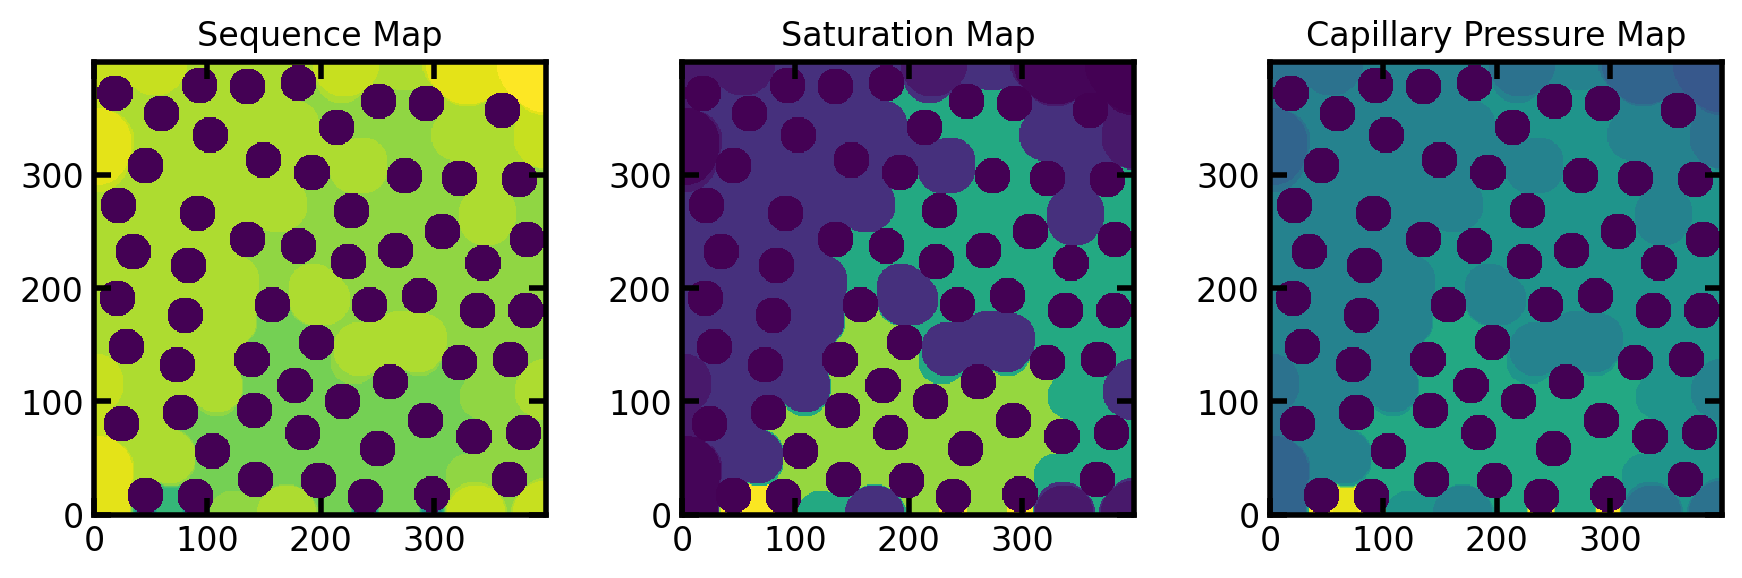

In [4]:
fig, ax = plt.subplots(1, 3, figsize=[9, 3])
ax[0].imshow(imb1.im_seq)
ax[1].imshow(imb1.im_snwp)
ax[2].imshow(imb1.im_pc, vmax=imb1.im_pc.max()/10)
ax[0].set_title("Sequence Map")
ax[1].set_title("Saturation Map")
ax[2].set_title("Capillary Pressure Map");

### Obtaining Specific Fluid Configurations

In Part 1 we use the sequence map to generate configuration.  Here we'll using the saturation map.  As the name suggests (`im_snwp`) this map contains the non-wetting phase saturation values.  If we want the wetting (invading) fluid locations, we find all locations in the saturation map which are *greater* than the desired saturation.

[0.         0.01334282 0.06678527 0.13833837 0.60639566 0.83999288
 0.99372887 0.99398684 0.99430706 0.99798079 0.99833659 0.99863903
 0.99895926 0.999066   0.99946629 0.99957303 0.99980431]


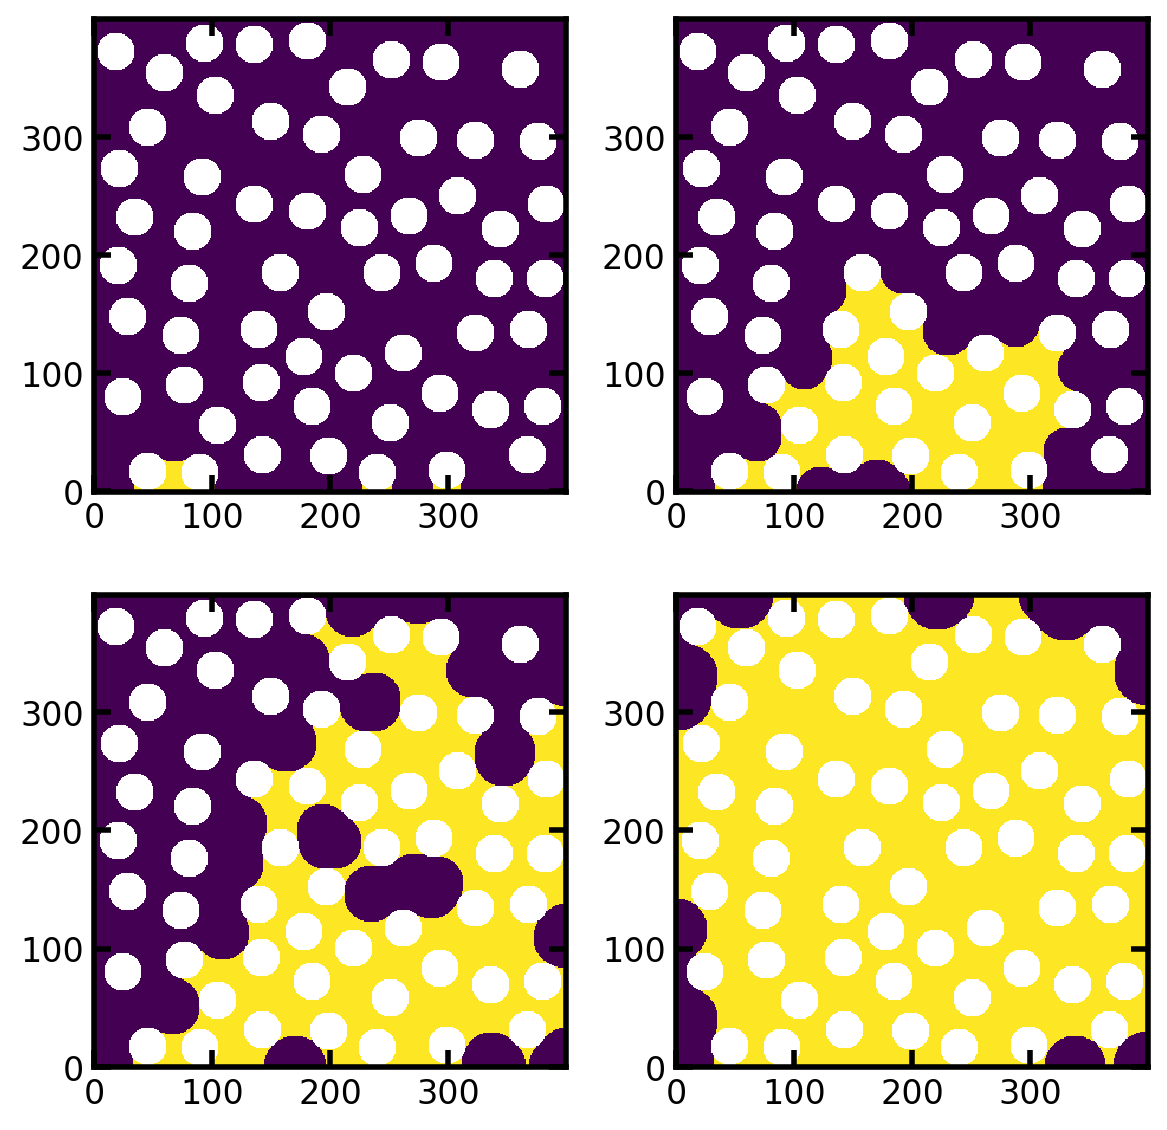

In [5]:
Snwp = np.unique(imb1.im_snwp[im])
print(Snwp)

fig, ax = plt.subplots(2, 2, figsize=(6, 6))
ax[0][0].imshow((imb1.im_snwp >= Snwp[6])/im)
ax[0][1].imshow((imb1.im_snwp >= Snwp[5])/im)
ax[1][0].imshow((imb1.im_snwp >= Snwp[4])/im)
ax[1][1].imshow((imb1.im_snwp >= Snwp[3])/im);

There is one very important *gotcha* to be aware of here.  It is not advisable to use an arbitrary value of saturation when applying the threshold. This is will (almost) never give the actual saturation requested. This is because the simulation occurs in discrete steps, so the saturation jumps between values of `S`. Instead it is recommended to find the unique values of `Snwp` in `im_snwp` and use those to perform the threshold, as we done above.  This will ensure that the result image will have the expected saturation.

### Generating Capillary Pressure Curves from Displacement Maps

As demonstrated in Part 1, the capillary pressure curve can be constructed by applying progressively lower thresholds to the capillary pressure map and counting the number of surviving voxels to get the saturation.  Again, care must be taken to ensure the curve is correct.  Specifically:

- The values in the capillary pressure map should be scanned in descending order.
- The threshold should be `<`, not `<=`.  This is because we are trying to find the wetting phase present at a given pressure, so we must exclude the non-wetting phase.
- Using the `<` means that the first data point occurs at `Snwp < 1.0`, so we should add an additional point at `(Pc, Snwp) = (Pc_max, 1.0)`.  This ensures that the endpoint of the curve starts at the correct spot.  

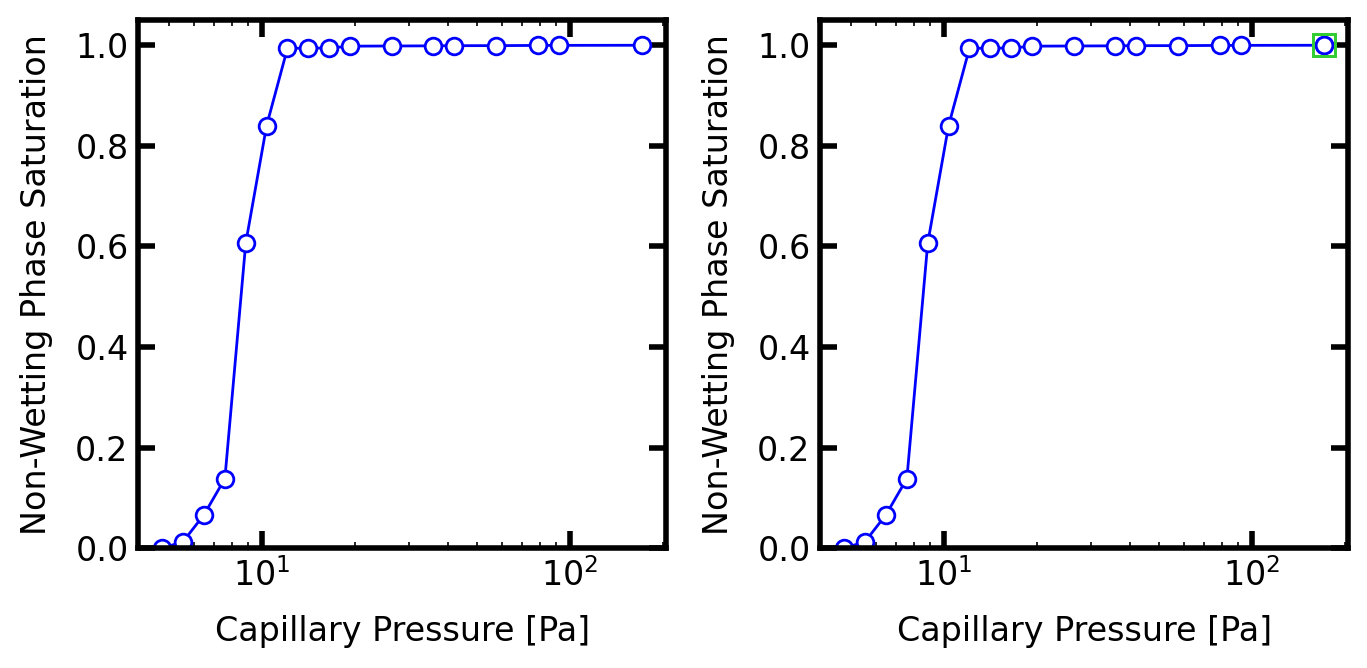

In [6]:
Pc = np.unique(imb1.im_pc[im])[-1::-1].tolist()
Snwp = []
for p in Pc:
    nwp = (imb1.im_pc < p)*im
    Snwp.append(nwp.sum()/im.sum())

fig, ax = plt.subplots(1, 2, figsize=[7, 3.5])
ax[0].semilogx(Pc, Snwp, marker='o', markersize=6, linewidth=1, color='blue')
ax[0].set_xlabel('Capillary Pressure [Pa]')
ax[0].set_ylabel('Non-Wetting Phase Saturation')
ax[0].set_ylim([0, 1.05])

Pc.insert(0, Pc[0])
Snwp.insert(0, 1.0)

ax[1].semilogx(
    Pc,
    Snwp,
    marker='o',
    markersize=6,
    linewidth=1,
    color='blue',
)
ax[1].semilogx(
    Pc[:2],
    Snwp[:2],
    marker='s',
    markersize=8,
    linewidth=2,
    color='limegreen',
    markerfacecolor='none',
)
ax[1].set_xlabel('Capillary Pressure [Pa]')
ax[1].set_ylabel('Non-Wetting Phase Saturation')
ax[1].set_ylim([0, 1.05]);

The above process is laborious, so PoreSpy offers a function to accomplish the same thing:

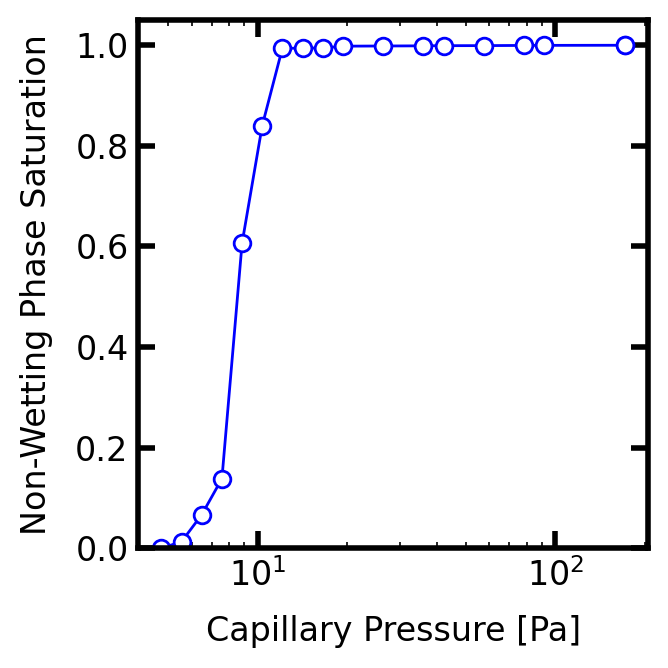

In [7]:
Pc, Snwp = ps.metrics.pc_map_to_pc_curve(
    pc=imb1.im_pc,
    im=im,
    mode='imbibition',
)

fig, ax = plt.subplots(figsize=[3.5, 3.5])
ax.semilogx(Pc, Snwp, marker='o', markersize=6, linewidth=1, color='blue')
ax.set_xlabel('Capillary Pressure [Pa]')
ax.set_ylabel('Non-Wetting Phase Saturation')
ax.set_ylim([0, 1.05]);

### Specifying Access Limitations or Not

When `inlets` is provided the invasion proceeds in an access limited manner, meaning that the invading wetting fluid can only enter regions which are connected to the inlets.  If `inlets` is not provided, then wetting fluid can appear anywhere within the domain.  This latter behavior can occur when the wetting fluid has low viscosity and/or the solid structure possesses many corners and crevices for the wetting fluid to flow, without actually displacing the fluid in the void space.  The following plot shows the capillary pressure curves for imbibition with and without access limitations.

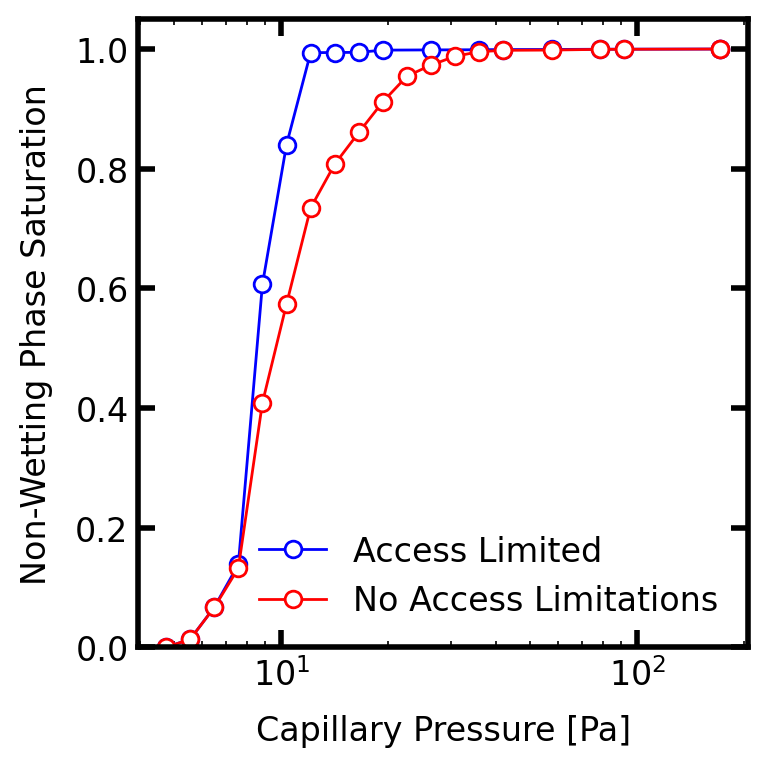

In [8]:
imb2 = ps.simulations.imbibition(
    im=im,
    pc=pc,
)

Pc2, Snwp2 = ps.metrics.pc_map_to_pc_curve(
    pc=imb2.im_pc,
    im=im,
    mode='imbibition',
)

fig, ax = plt.subplots(figsize=[4, 4])
ax.semilogx(
    Pc,
    Snwp,
    marker='o',
    markersize=6,
    linewidth=1,
    color='blue',
    label='Access Limited',
)
ax.semilogx(
    Pc2,
    Snwp2,
    marker='o',
    markersize=6,
    linewidth=1,
    color='red',
    label='No Access Limitations',
)
ax.set_xlabel('Capillary Pressure [Pa]')
ax.set_ylabel('Non-Wetting Phase Saturation')
ax.set_ylim([0, 1.05])
ax.legend();

### Incorporating Trapping and Residual Phase in Imbibition

Imbibition can begin in the presence of some residual wetting phase which was perhaps trapped during a previous drainage cycle. Trapping of non-wetting phase can also occurring during imbibition.  Both these effects can be considered by the `imbibition` algorithm.

Trapping is automatically accounted for if `outlets` are provided.  

In [9]:
outlets = ps.generators.faces(im.shape, outlet=0)
imb3 = ps.simulations.imbibition(
    im=im,
    pc=pc,
    inlets=inlets,
    outlets=outlets,
)

The displacement maps for this process are shown below:

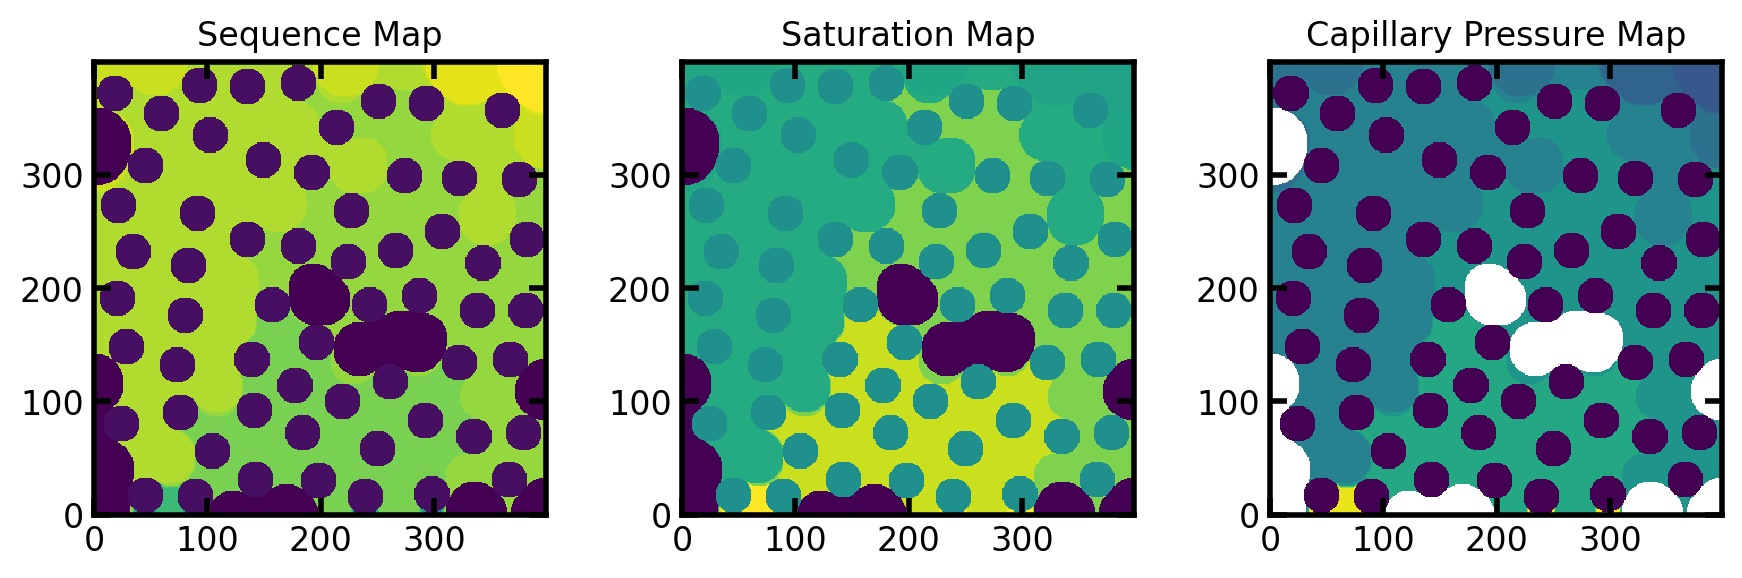

In [10]:
fig, ax = plt.subplots(1, 3, figsize=[9, 3])
ax[0].imshow(imb3.im_seq)
ax[1].imshow(imb3.im_snwp)
ax[2].imshow(imb3.im_pc, vmax=imb3.im_pc.max()/10)
ax[0].set_title("Sequence Map")
ax[1].set_title("Saturation Map")
ax[2].set_title("Capillary Pressure Map");

In the sequence map the trapped voxels are indicated by `-1`, which is also the case for the saturation map.  This allows for wetting phase configurations to be generated using thresholding (i.e. `Swp = im_snwp > p`). In the capillary pressure map the trapped non-wetting phase is indicated by `-inf`, which is physically consistent with the fact that these voxels would be filled with non-wetting phase at all pressures.

As usual generating a capillary pressure is done by applying the necessary thresholds to the capillary pressure map.  Using the built-in PoreSpy function yields:

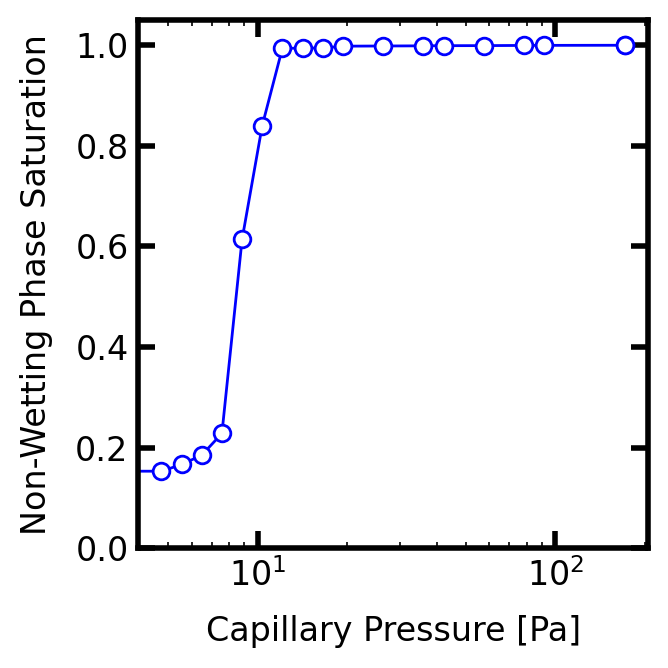

In [11]:
Pc3, Snwp3 = ps.metrics.pc_map_to_pc_curve(
    im=im,
    pc=imb3.im_pc,
    mode='imbibition',
)

fig, ax = plt.subplots(figsize=[3.5, 3.5])
ax.semilogx(
    Pc3,
    Snwp3,
    marker='o',
    markersize=6,
    linewidth=1,
    color='blue',
)
ax.set_xlabel('Capillary Pressure [Pa]')
ax.set_ylabel('Non-Wetting Phase Saturation')
ax.set_ylim([0, 1.05]);

Incorporating residual wetting phase is accomplished by providing a mask of which locations are initially filled, as follows:

In [12]:
residual = ps.filters.local_thickness(im) < 7
imb4 = ps.simulations.imbibition(
    im=im,
    pc=pc,
    inlets=inlets,
    outlets=outlets,
    residual=residual,
)

Which results in the following displacement maps:

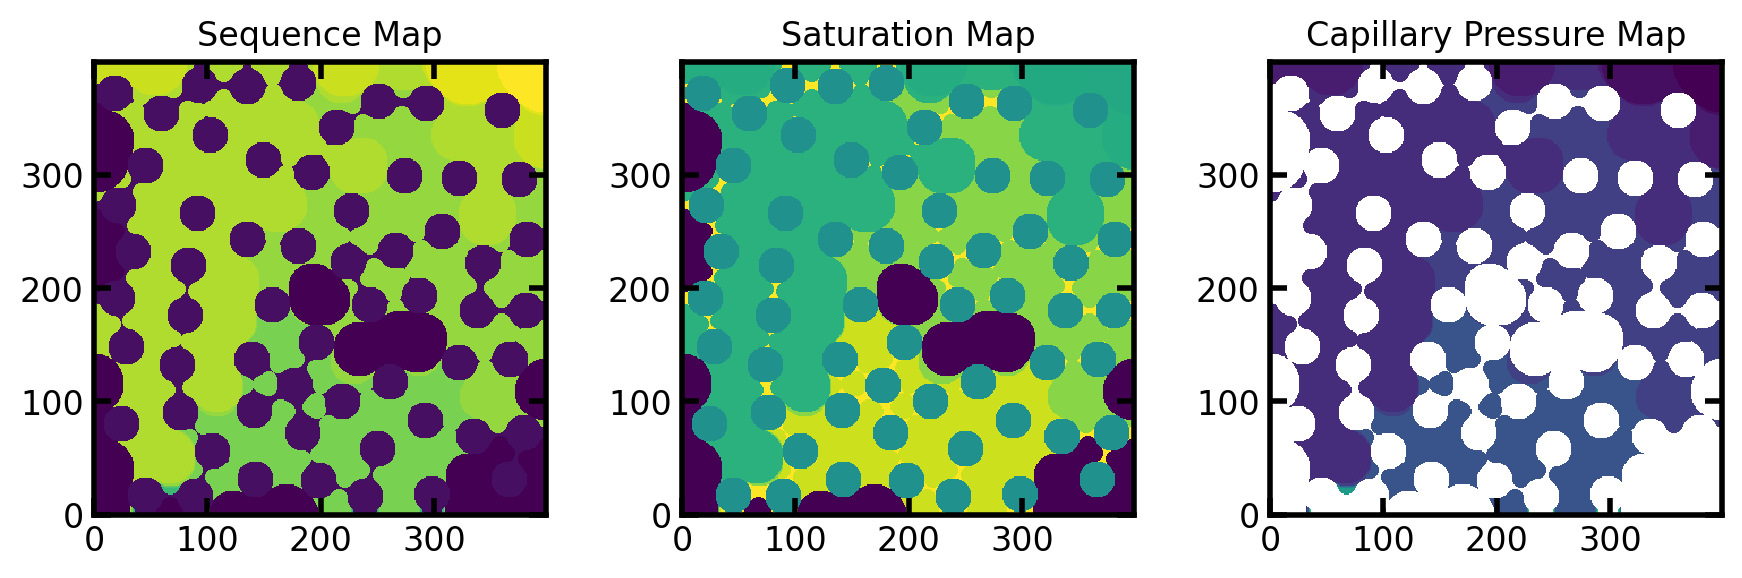

In [13]:
fig, ax = plt.subplots(1, 3, figsize=[9, 3])
ax[0].imshow(imb4.im_seq)
ax[1].imshow(imb4.im_snwp)
ax[2].imshow(imb4.im_pc)
ax[0].set_title("Sequence Map")
ax[1].set_title("Saturation Map")
ax[2].set_title("Capillary Pressure Map");

These results contain both residual wetting phase and trapped non-wetting phase. In the sequence map the residual wetting phase is labelled with `0` since it is invaded before the first step, and the trapped non-wetting phase is labelled with `-1`.  In the saturation map the trapped non-wetting phase is also labelled with `-1`, while the residual wetting phase has a value `1-Swpr`. This is consistent with the fact that the non-wetting phase saturation never reached `1.0`. Lastly, the capillary pressure map has `-inf` for trapped non-wetting phase and `+inf` for residual wetting phase. This represents the fact that not all wetting phase is displaced at `+inf` (i.e. it becomes residual wetting phase) and not all non-wetting phase is displaced even at `-inf` hence it becomes trapped.

Plotting the capillary pressure curve shows plateaus at both `Snwp < 1.0` and `Snwp > 0.0`:

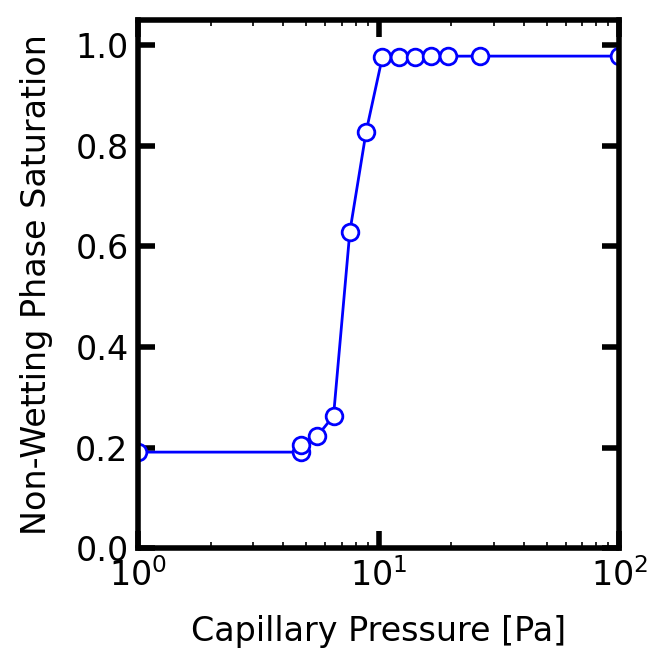

In [14]:
Pc4, Snwp4 = ps.metrics.pc_map_to_pc_curve(
    im=im,
    pc=imb4.im_pc,
    mode='drainage',
    pc_min=1,
    pc_max=100,
)

fig, ax = plt.subplots(figsize=[3.5, 3.5])
ax.semilogx(
    Pc4,
    Snwp4,
    marker='o',
    markersize=6,
    linewidth=1,
    color='blue',
)
ax.set_xlabel('Capillary Pressure [Pa]')
ax.set_ylabel('Non-Wetting Phase Saturation')
ax.set_xlim([1, 100])
ax.set_ylim([0, 1.05]);

When calling `pc_map_to_pc_curve` above, the `pc_min` and `pc_max` arguments were given. This tells the function to clip the range of capillary pressures between these two values.  This is useful for replacing the `-inf` and `+inf` values with finite value which facilitate plotting (`1` and `100` Pa in this case).

## Summary

In conclusion, the `imbibition` algorithm in PoreSpy's `simulations` module can be used to model the invasion of wetting phase into a porous domain, including the effects of trapping by `outlets` and the presence of residual wetting phase by specifying `residual`. Access limitations can be applied by specifying `inlets` or wetting phase can be allowed to appear anywhere within the domain by omitted `inlets`.  

The function returns a `Results` object which is `dataclass-like` object which has several displacement maps as attributes.  The displacement maps contain the entire history of the invasion sequence so that any given fluid configuration can be obtained using an appropriate threshold.  The following table outlines the values used in each displacement map to indicate the trapped and residual fluid, along with a code snippet to generate a given configuration from each.

+-------------------+--------------+-----------------+------------------------------------+
| Displacement Map  | Trapped NWP  | Residual WP     | Code to Generate Swp               |
+-------------------+--------------+-----------------+------------------------------------+
| Pc Map            | $-inf$       | $+inf$          | `(im_pc > p) * im`                 |
+-------------------+--------------+-----------------+------------------------------------+
| Sequence Map      | -1           | 0               | `(im_seq < N) * (im_seq >= 0)`     |
+-------------------+--------------+-----------------+------------------------------------+
| Saturation Map    | -1           | $1 - S_{wp,r}$  | `(im_snwp > s)`                    |
+-------------------+--------------+-----------------+------------------------------------+